# Spatiotemporal Analysis of Urban Vegetation (NDVI) and Land Surface Temperature (LST)

Extracted from: 'Spatiotemporal Analysis of Urban Vegetation and Land Surface Temperature Using STAC, Planetary Computer, and Xarray' (Medium).

This notebook pulls together the code steps to: install dependencies, connect to Planetary Computer STAC, load a study area (AOI), search Landsat 8 images, build a data cube with ODC-STAC, compute NDVI and LST, visualize maps, and plot time trends.

## 1) Install required packages (pip)

You may skip if already installed.

In [2]:
%pip install -q pystac-client planetary-computer odc-stac xarray geopandas rioxarray rasterio matplotlib

Note: you may need to restart the kernel to use updated packages.


## 2) Imports and setup

In [3]:
from pystac_client import Client
import planetary_computer
import xarray as xr
from odc.stac import stac_load
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray  # noqa: F401  # register .rio accessor
import urllib.request
import numpy as np
import warnings
import os
geojson from shapely.geometry import shape, Polygon

warnings.filterwarnings('ignore')
xr.set_options(keep_attrs=True);

## 3) Connect to Planetary Computer STAC API

In [4]:
planetary_computer_api = 'https://planetarycomputer.microsoft.com/api/stac/v1/'
catalog = Client.open(
    planetary_computer_api,
    modifier=planetary_computer.sign_inplace
)
catalog

<Client id=microsoft-pc>

## 4) Load AOI and compute bounding box

- Replace `aoi_path` with your boundary file (GeoJSON/Shapefile/GeoPackage).
- This cell dissolves features into a single geometry and computes a [minx, miny, maxx, maxy] bbox.

In [8]:
# Update this path to your AOI file. As a convenience, will fall back to 'polygons.gpkg' if present.
aoi_path = 'rural_australia.geojson'

boundary = gpd.read_file(aoi_path)
boundary = boundary.to_crs(4326)

# Try to dissolve by a likely column name; else dissolve all
if 'ADM1NAME_' in boundary.columns:
    boundary_dissolved = boundary.dissolve(by='ADM1NAME_')
else:
    boundary['__dissolve__'] = 1
    boundary_dissolved = boundary.dissolve(by='__dissolve__')
    boundary_dissolved = boundary_dissolved.drop(columns=['__dissolve__'], errors='ignore')

# Compute [minx, miny, maxx, maxy]
bbox = boundary_dissolved.total_bounds.tolist()
print('BBox:', bbox)

# Optional: quick interactive map (requires geopandas 0.10+ and folium)
try:
    boundary_dissolved.explore()
except Exception as e:
    print('Map preview unavailable:', e)

BBox: [144.9975, -31.0025, 145.0025, -30.9975]
Map preview unavailable: The 'folium>=0.12', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge "folium>=0.12" matplotlib mapclassify' or 'pip install "folium>=0.12" matplotlib mapclassify'.


## 5) Search Landsat 8 Collection 2 Level-2 with <20% cloud cover (2014–2024)

In [25]:
results = catalog.search(
    collections=['landsat-c2-l2'],
    bbox=bbox,
    datetime=['2024-06-01', '2024-12-31'],
    query={
        'eo:cloud_cover': {'lt': 20},
        'platform': {'in': ['landsat-8']}
    }
)

items = list(results.get_items())
print(f'Found {len(items)} items')
if not items:
    raise ValueError('No items found. Try relaxing filters or checking your AOI/time range.')

item = items[0]
item

Found 18 items


<Item id=LC08_L2SP_094082_20241225_02_T1>

## 6) Explore image footprint and preview thumbnail

Map preview unavailable: The 'folium>=0.12', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge "folium>=0.12" matplotlib mapclassify' or 'pip install "folium>=0.12" matplotlib mapclassify'.


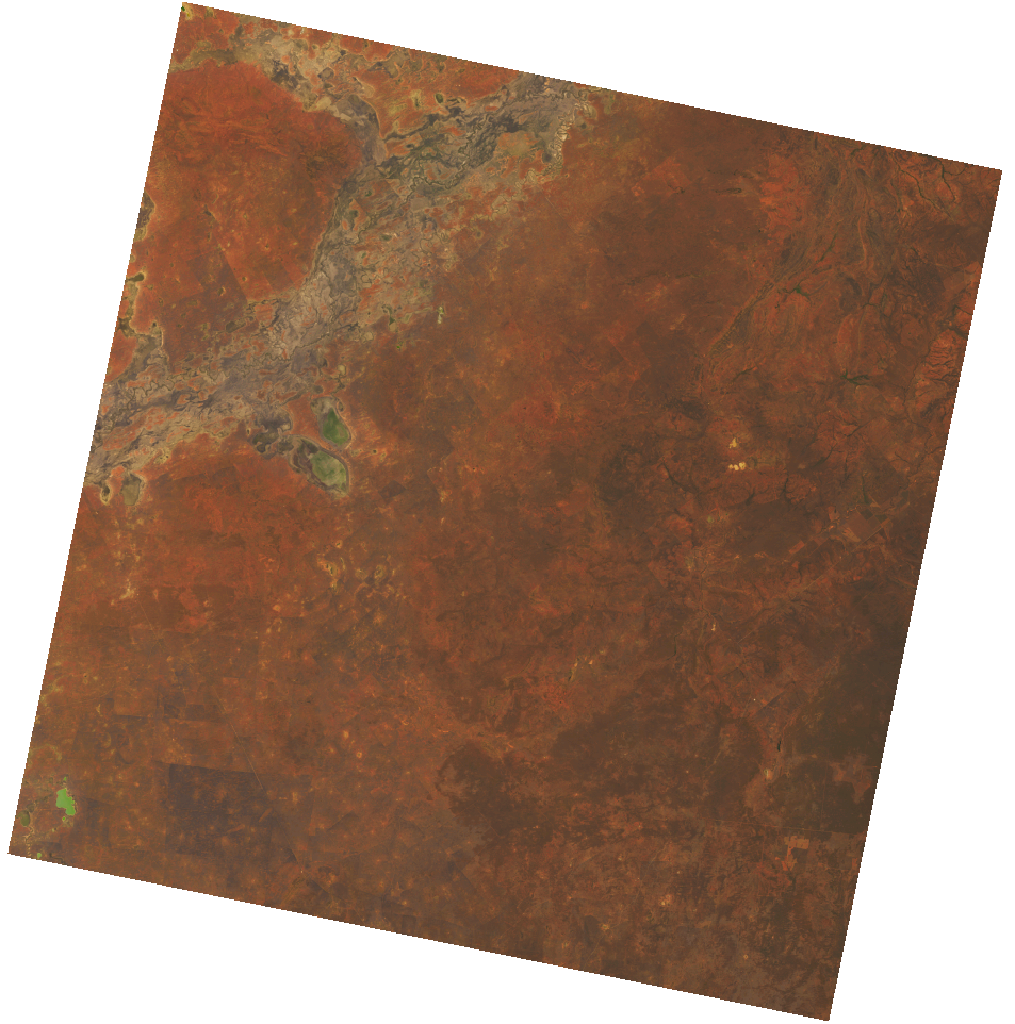

In [26]:
# Footprint as GeoDataFrame
geom = shape(item.geometry)
gdf = gpd.GeoDataFrame({'id': [item.id]}, geometry=[geom], crs='EPSG:4326')
try:
    gdf.explore()
except Exception as e:
    print('Map preview unavailable:', e)

# Thumbnail preview
from IPython.display import Image, display
url = item.assets['rendered_preview'].href
_ = urllib.request.urlretrieve(url, 'preview.jpg')
display(Image('preview.jpg'))

## 7) Load and stack imagery into a data cube (ODC-STAC)
Select bands for NDVI (red, nir08) and for LST (lwir11).

In [28]:
bands = ['blue', 'green', 'red', 'nir08', 'lwir11']
data = stac_load(items=items, bands=bands, bbox=bbox, groupby='time')
data

<xarray.Dataset> Size: 62kB
Dimensions:      (y: 20, x: 17, time: 18)
Coordinates:
  * y            (y) float64 160B -3.431e+06 -3.431e+06 ... -3.432e+06
  * x            (x) float64 136B 3.088e+05 3.088e+05 ... 3.093e+05 3.093e+05
    spatial_ref  int32 4B 32655
  * time         (time) datetime64[ns] 144B 2024-06-16T00:13:21.619259 ... 20...
Data variables:
    blue         (time, y, x) uint16 12kB 31546 28111 28038 ... 8398 8480 8539
    green        (time, y, x) uint16 12kB 32564 29267 28582 ... 9424 9583 9697
    red          (time, y, x) uint16 12kB 34201 30829 30279 ... 11715 11938
    nir08        (time, y, x) uint16 12kB 37306 34122 33504 ... 15387 15527
    lwir11       (time, y, x) uint16 12kB 38904 38918 38944 ... 51065 51075

## 8) Aggregate to yearly time steps

In [29]:
data_yearly = data.resample(time='1M').median()
data_yearly

<xarray.Dataset> Size: 96kB
Dimensions:      (time: 7, y: 20, x: 17)
Coordinates:
  * y            (y) float64 160B -3.431e+06 -3.431e+06 ... -3.432e+06
  * x            (x) float64 136B 3.088e+05 3.088e+05 ... 3.093e+05 3.093e+05
    spatial_ref  int32 4B 32655
  * time         (time) datetime64[ns] 56B 2024-06-30 2024-07-31 ... 2024-12-31
Data variables:
    blue         (time, y, x) float64 19kB 3.155e+04 2.811e+04 ... 8.574e+03
    green        (time, y, x) float64 19kB 3.256e+04 2.927e+04 ... 9.714e+03
    red          (time, y, x) float64 19kB 3.42e+04 3.083e+04 ... 1.195e+04
    nir08        (time, y, x) float64 19kB 3.731e+04 3.412e+04 ... 1.553e+04
    lwir11       (time, y, x) float64 19kB 3.89e+04 3.892e+04 ... 5.108e+04

## 9) NDVI: compute and visualize

<Figure size 1000x500 with 0 Axes>

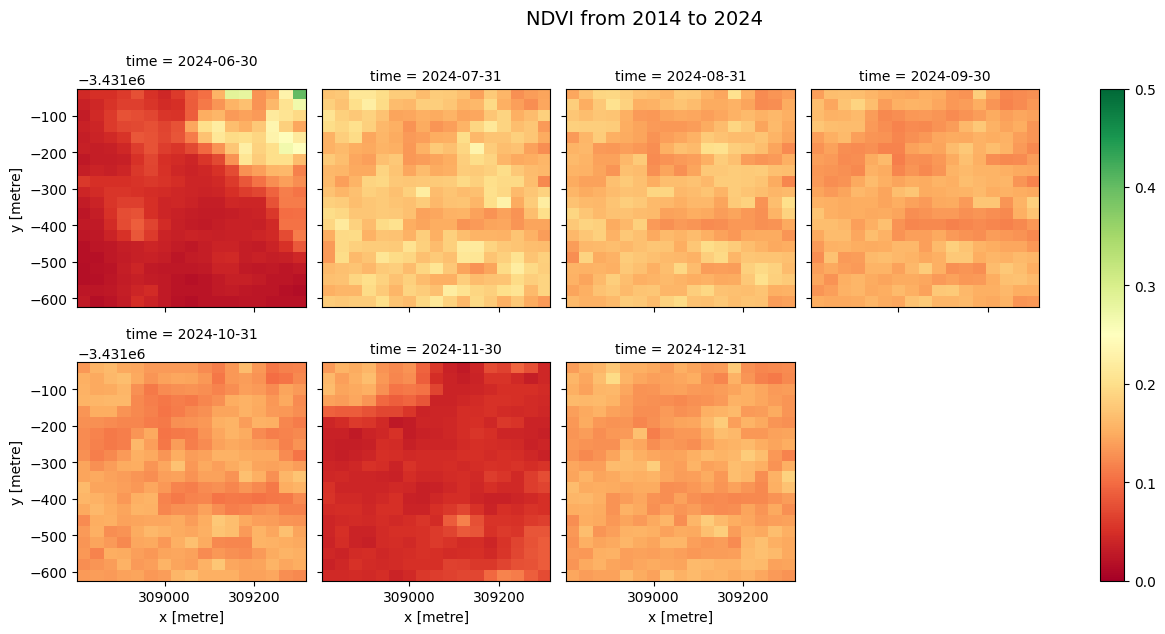

<xarray.DataArray (time: 7, y: 20, x: 17)> Size: 19kB
array([[[0.04342232, 0.05069976, 0.05056206, ..., 0.14457763,
         0.23125134, 0.40109334],
        [0.03517507, 0.04144451, 0.05463709, ..., 0.1602131 ,
         0.20533299, 0.26803544],
        [0.02992098, 0.0435287 , 0.06006165, ..., 0.21864595,
         0.20727511, 0.19348679],
        ...,
        [0.01685633, 0.01869521, 0.02452417, ..., 0.02400344,
         0.02448532, 0.02070377],
        [0.025078  , 0.02354458, 0.02615028, ..., 0.02373041,
         0.01894167, 0.01558889],
        [0.02868469, 0.01712706, 0.02202216, ..., 0.0210405 ,
         0.02094474, 0.02048509]],

       [[0.17234421, 0.1760153 , 0.21258574, ..., 0.1285185 ,
         0.13861257, 0.14390791],
        [0.18493343, 0.17148467, 0.20056788, ..., 0.14048587,
         0.12500833, 0.14557811],
        [0.20706702, 0.18478657, 0.17657263, ..., 0.15271548,
         0.16598496, 0.18389041],
...
        [0.04274957, 0.03745978, 0.04551791, ..., 0.06916896,
         0.08153871, 0.08614865],
        [0.03688897, 0.04145078, 0.05079251, ..., 0.07693957,
         0.07868992, 0.08679283],
        [0.04391789, 0.0442339 , 0.04593255, ..., 0.11220222,
         0.08950202, 0.07367682]],

       [[0.13708121, 0.1538924 , 0.15961587, ..., 0.12065847,
         0.12162932, 0.12365601],
        [0.15971003, 0.14533915, 0.16759475, ..., 0.11642799,
         0.10941148, 0.12195761],
        [0.15389073, 0.14107815, 0.15948619, ..., 0.14551288,
         0.13566275, 0.13845077],
        ...,
        [0.13645461, 0.13388003, 0.15387502, ..., 0.16823833,
         0.1623935 , 0.14800515],
        [0.13194229, 0.14756565, 0.15530676, ..., 0.16315087,
         0.14213986, 0.14411776],
        [0.14495322, 0.13708382, 0.14223605, ..., 0.14557546,
         0.13486024, 0.13032089]]], shape=(7, 20, 17))
Coordinates:
  * y            (y) float64 160B -3.431e+06 -3.431e+06 ... -3.432e+06
  * x            (x) float64 136B 3.088e+05 3.088e+05 ... 3.093e+05 3.093e+05
    spatial_ref  int32 4B 32655
  * time         (time) datetime64[ns] 56B 2024-06-30 2024-07-31 ... 2024-12-31
Attributes:
    nodata:   0

In [30]:
nir = data_yearly['nir08']
red = data_yearly['red']
NDVI = (nir - red) / (nir + red)

plt.figure(figsize=(10, 5))
NDVI.plot.imshow(col='time', col_wrap=4, vmin=0, vmax=0.5, cmap='RdYlGn')
plt.suptitle('NDVI from 2014 to 2024', fontsize=14, y=1.05)
plt.show()

NDVI

### Optional: export NDVI stack to GeoTIFF

In [31]:
NDVI.rio.to_raster('NDVI_2014_2024.tif')
'Wrote NDVI_2014_2024.tif'

'Wrote NDVI_2014_2024.tif'

## 10) LST: compute from thermal band and visualize

Scale factor and constants per Landsat 8 C2 L2 documentation.

<Figure size 1000x500 with 0 Axes>

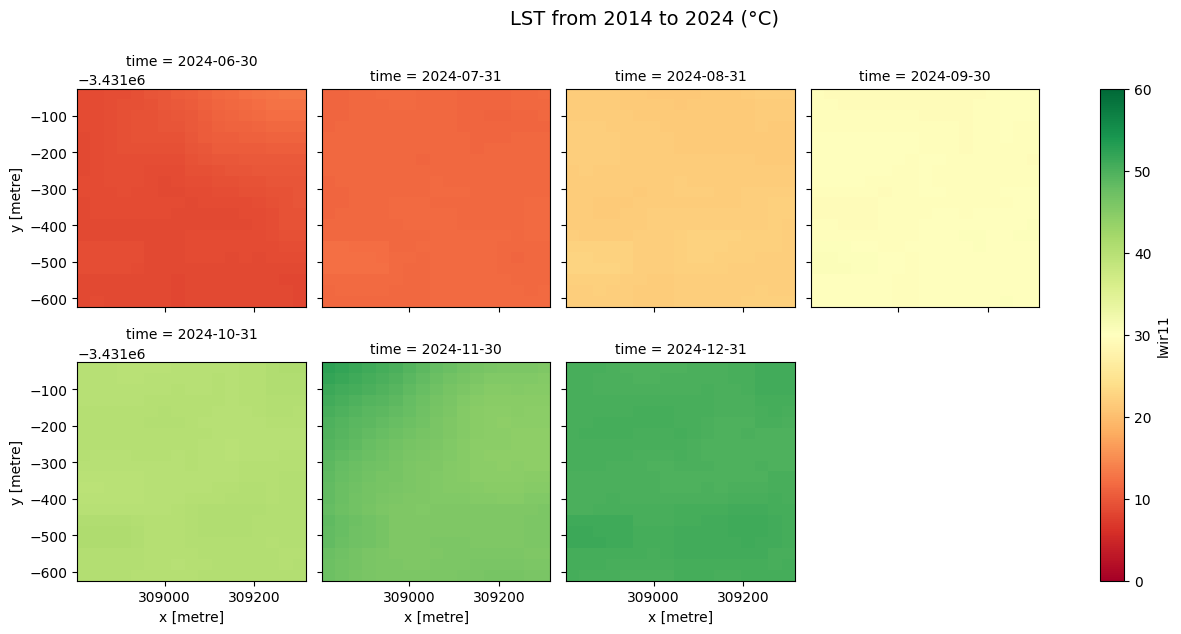

<xarray.DataArray 'lwir11' (time: 7, y: 20, x: 17)> Size: 19kB
array([[[ 8.82465008,  8.87250236,  8.96137088, ..., 12.8271515 ,
         12.8955119 , 12.93652814],
        [ 8.7084374 ,  8.8451582 ,  8.98871504, ..., 12.45800534,
         12.5024396 , 12.48876752],
        [ 8.69818334,  8.83490414,  9.04340336, ..., 12.06493304,
         12.06835106, 11.96922848],
        ...,
        [ 8.65374908,  8.66400314,  8.61956888, ...,  8.60931482,
          8.42474174,  8.39397956],
        [ 8.6571671 ,  8.66058512,  8.6229869 , ...,  8.64349502,
          8.4520859 ,  8.3837255 ],
        [ 8.66058512,  8.6742572 ,  8.65374908, ...,  8.6571671 ,
          8.44866788,  8.35979936]],

       [[11.37278399, 11.45310746, 11.57444717, ..., 11.63597153,
         11.70604094, 11.78123738],
        [11.374493  , 11.45481647, 11.56932014, ..., 11.4941237 ,
         11.54710301, 11.62229945],
        [11.39841914, 11.47361558, 11.56761113, ..., 11.4086732 ,
         11.43089033, 11.49070568],
...
        [47.47220222, 46.91848298, 46.48439444, ..., 45.8281346 ,
         45.56836508, 45.59912726],
        [47.30813726, 46.80568832, 46.4262881 , ..., 46.07765006,
         45.83838866, 45.83838866],
        [47.15090834, 46.70656574, 46.38527186, ..., 46.27589522,
         46.07081402, 46.09132214]],

       [[50.37239219, 50.26985159, 50.17072901, ..., 50.69539508,
         50.80818974, 50.84578796],
        [50.33308496, 50.2202903 , 50.14680287, ..., 50.69026805,
         50.77913657, 50.83211588],
        [50.2715606 , 50.17414703, 50.15534792, ..., 50.62532567,
         50.72444825, 50.75691944],
        ...,
        [50.5962725 , 50.57576438, 50.5450022 , ..., 50.66121488,
         50.37068318, 50.35188407],
        [50.48347784, 50.4595517 , 50.42878952, ..., 50.58089141,
         50.37751922, 50.40999041],
        [50.39631833, 50.37922823, 50.33308496, ..., 50.55696527,
         50.39290031, 50.4253715 ]]], shape=(7, 20, 17))
Coordinates:
  * y            (y) float64 160B -3.431e+06 -3.431e+06 ... -3.432e+06
  * x            (x) float64 136B 3.088e+05 3.088e+05 ... 3.093e+05 3.093e+05
    spatial_ref  int32 4B 32655
  * time         (time) datetime64[ns] 56B 2024-06-30 2024-07-31 ... 2024-12-31
Attributes:
    nodata:   0

In [32]:
scale_factor = 0.00341802
k = 149.0
conversion_celsius = 273.15

LST = (data_yearly['lwir11'] * scale_factor + k) - conversion_celsius

plt.figure(figsize=(10, 5))
LST.plot.imshow(col='time', col_wrap=4, vmin=0, vmax=60, cmap='RdYlGn')
plt.suptitle('LST from 2014 to 2024 (°C)', fontsize=14, y=1.05)
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.show()

LST

### Optional: export LST layers per time step

In [33]:
for t in LST.time.values:
    out = f"LST_{np.datetime_as_string(t, unit='D')}.tif"
    LST.sel(time=t).rio.to_raster(out)
out

'LST_2024-12-31.tif'

## 11) Trend analysis: spatial means over time

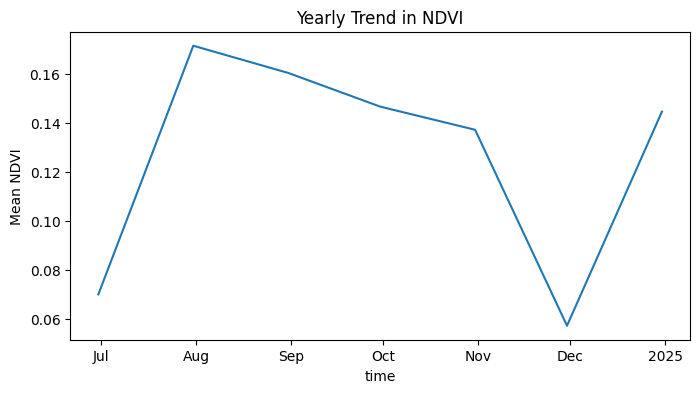

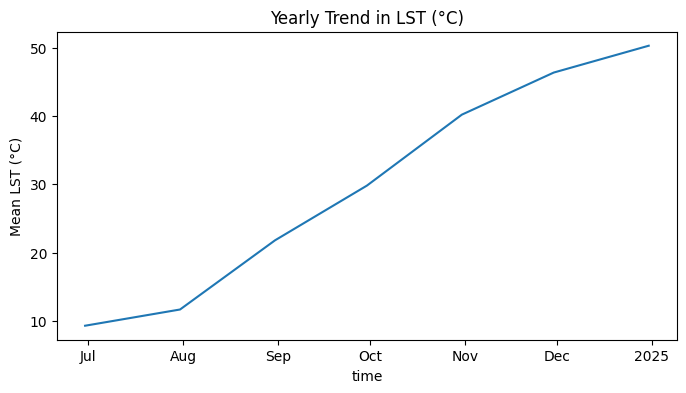

In [34]:
NDVI_mean = NDVI.mean(dim=['y', 'x'])
LST_mean = LST.mean(dim=['y', 'x'])

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
NDVI_mean.plot(ax=ax)
ax.set_title('Yearly Trend in NDVI')
ax.set_ylabel('Mean NDVI')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
LST_mean.plot(ax=ax)
ax.set_title('Yearly Trend in LST (°C)')
ax.set_ylabel('Mean LST (°C)')
plt.show()